Inspired by **CNN Exercise - Deep Learning for Computer Vision** on [Kaggle](https://www.kaggle.com/code/mgmarques/cnn-exercise-deep-learning-for-computer-vision) 

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
#import torchvision.datasets as datasets 
#import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [2]:
class CIFARDataset(Dataset):

    def __init__(self,path,filenames):
        self.data_dict = self.load_data(path,filenames)
        self.class_names = self.unpickle(os.path.join(path,'batches.meta'))[b'label_names']
        self.class_names = list(map(lambda x: x.decode('UTF-8'), self.class_names))
        self.images = torch.tensor(self.data_dict[b'data'].reshape(-1,3,32,32))/255
        self.labels = torch.tensor(self.data_dict[b'labels']).unsqueeze(1)
        
    def __getitem__(self,index):
        # Get one item from the dataset
        return self.images[index], self.labels[index]
    
    def __len__(self):
        return len(self.images)
    
    def load_data(self,path,filenames):
        data_dict = {}
        for filename in filenames:
            batch_dict = self.unpickle(os.path.join(path_data,filename))
            if len(data_dict)==0:
                data_dict = batch_dict
            else:
                data_dict[b'labels'] += batch_dict[b'labels']  
                data_dict[b'data'] = np.vstack((data_dict[b'data'],batch_dict[b'data']))
        return data_dict
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [3]:
def show_sample_image(dataset, idx=0):
    image, label = dataset[idx]
    label = label.item()
    image = image.numpy().T
    flipped_image = np.zeros(image.shape)
    flipped_image[:,:, 0] = image[:,:, 0].T
    flipped_image[:,:, 1] = image[:,:, 1].T
    flipped_image[:,:, 2] = image[:,:, 2].T
    title = dataset.class_names[label]
    plt.subplots(figsize=(1,1))
    plt.imshow(flipped_image, interpolation='nearest')
    _=plt.xticks([])
    _=plt.yticks([])
    _=plt.title(title)
    plt.show()
    return flipped_image, label

In [4]:
class CIFARCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=8192, out_features=1024)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=1024, out_features=10)
        
    def forward(self,x):
        
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        out = out.view(-1,8192)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        
        return out

In [5]:
path_data = './data/cifar-10-batches-py/'
batchfiles = os.listdir(path_data)
train_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test_batches = ['test_batch']

batch_size = 200

In [6]:
train_dataset = CIFARDataset(path_data, train_batches)
test_dataset = CIFARDataset(path_data, test_batches)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

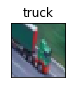

In [7]:
image, label = show_sample_image(train_dataset, idx=50)

test the mdel

In [8]:
model = CIFARCNN()

images, labels = train_dataset[0:10]

out = model(images)